# 155.ImageDataGenerator 를 이용한 data feed 구조화 및 Data Augmentation

- https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip 에서 2,000 장의 JPG file 을 download 하여 압축 해제

**NOTE:** Kaggle 의 ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) 의 25,000 개 image 중 교육용으로 2,000 장 발췌.

- 소량의 image data (2000 장) 를 이용하여 model 을 학습하여 overfitting 을 유도한 후 image augmentation 을 통한 overfitting 해결 

In [0]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=_URL, extract=True)
data_dir = os.path.dirname(path_to_zip)
data_dir

68608000/68606236 [==============================] - 1s 0us/step


'/root/.keras/datasets'

In [3]:
!ls /root/.keras/datasets

cats_and_dogs_filtered	cats_and_dogs_filtered.zip


**/tmp/cats_and_dogs_filtered directory 의 `train`과 `validation` subdirectory 에 training 과 validation datasets 이 구분되어 있고 각 directory 는 `cats` and `dogs` subdirectory 로 구성 $\rightarrow$ ImageDataGenerator 가 directory 정보을 이용하여 자동으로 labeling.**

In [0]:
base_dir = os.path.join(data_dir, 'cats_and_dogs_filtered')

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [5]:
validation_dogs_dir

'/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs'

In [6]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.591.jpg', 'cat.316.jpg', 'cat.116.jpg', 'cat.206.jpg', 'cat.908.jpg', 'cat.109.jpg', 'cat.125.jpg', 'cat.34.jpg', 'cat.484.jpg', 'cat.331.jpg']
['dog.115.jpg', 'dog.858.jpg', 'dog.755.jpg', 'dog.948.jpg', 'dog.515.jpg', 'dog.388.jpg', 'dog.600.jpg', 'dog.145.jpg', 'dog.32.jpg', 'dog.489.jpg']


In [7]:
print('total training cat images :', len(os.listdir( train_cats_dir ) ))
print('total training dog images :', len(os.listdir( train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


### 개와 고양이 사진 각 8 장씩 display  

- matplotlib.image.imread(fname) : image 를 읽어서 numpy array 로 변환
- matplotlib.pyplot.imshow : image display

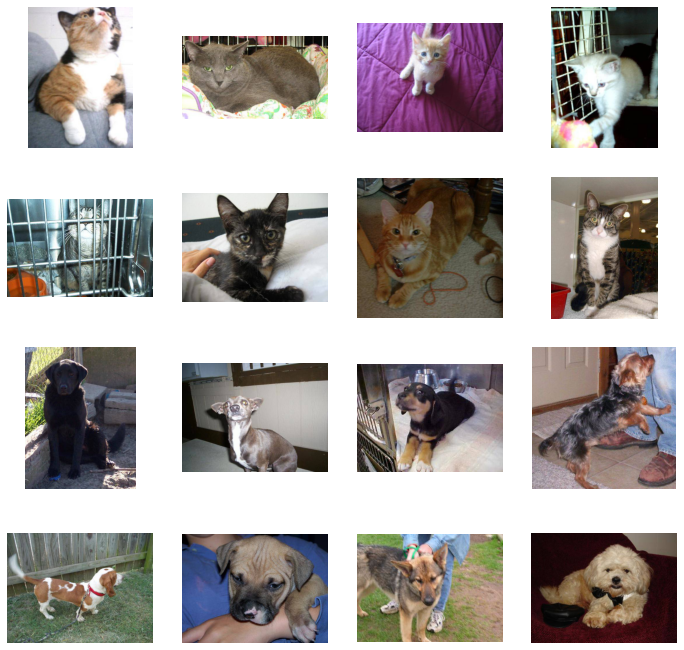

In [8]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 4, figsize=(12, 12))
cats = [os.path.join(train_cats_dir, fname) for fname in train_cat_fnames[:8]]
dogs = [os.path.join(train_dogs_dir, fname) for fname in train_dog_fnames[:8]]
ax = ax.ravel()

for i, img_path in enumerate(cats + dogs):
    img = mpimg.imread(img_path)
    ax[i].imshow(img)
    ax[i].axis('off')

## training accuracy 99% 와 validation accuracy 약 70% 인 overfitting small model 작성

### image preprocessing 

- 사진들의 크기가 제각각이고 고양이와 개가 사람이나 다른 물건과 섞여 있는 image 들이므로 150x150 size 로 통일  


- size 150x150x3 의 color image

- output : 0 ('cats'), 1 ('dogs')

- convolution layers : feature map 의 size 축소 

- pooling layer : 차원을 반으로 감축

In [0]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

- optimizer 는 RMSprop, Adam, Adagrad 중 택일 $\rightarrow$ 자동으로 learning rate 조절

    - [RMSprop optimization algorithm](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) 
    - [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) 
    - [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad)

In [0]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics = ['acc'])

### Data Augmentation 없는 Data 전처리 

- image generator   

    - source image 를 읽어 float32 tensor 로 변환하여 label 과 함께 network 에 공급 
    - 150x150 size 의 20 개 image 를 1 batch 로 생성 + labels (binary)
    
    
- training image 용 image generator 와 validation 용 image generator 를 별개로 생성  


- image pixel 값을 [0, 255] $\rightarrow$ [0, 1] 로 normalize  $\rightarrow$ `rescale` parameter 이용
    
    
- image generator 에서 생성된 data 는 model 의 다음 method 를 이용하여 처리

    - train : fit_generator( )
    - 평가 : evaluate_generator( )
    - 예측 : predict_generator( )

In [12]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.)
test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Training

- 2000 개 training image 와 1000 개 validation image 를 이용하여 15 epoch 수행

- steps_per_epoch = n_samples / batch_size (n_samples : total number of training data)

In [13]:
%%time
history = model.fit_generator(train_generator,
                              validation_data=validation_generator,
                              epochs=15,
                              verbose=2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
100/100 - 8s - loss: 0.8465 - acc: 0.5310 - val_loss: 0.6716 - val_acc: 0.6330
Epoch 2/15
100/100 - 8s - loss: 0.6601 - acc: 0.6360 - val_loss: 0.6129 - val_acc: 0.6510
Epoch 3/15
100/100 - 8s - loss: 0.5672 - acc: 0.7040 - val_loss: 0.6525 - val_acc: 0.6100
Epoch 4/15
100/100 - 8s - loss: 0.4861 - acc: 0.7730 - val_loss: 0.6189 - val_acc: 0.6950
Epoch 5/15
100/100 - 8s - loss: 0.4210 - acc: 0.8075 - val_loss: 0.6696 - val_acc: 0.6960
Epoch 6/15
100/100 - 8s - loss: 0.3220 - acc: 0.8540 - val_loss: 0.6824 - val_acc: 0.7170
Epoch 7/15
100/100 - 8s - loss: 0.2681 - acc: 0.8950 - val_loss: 0.7684 - val_acc: 0.6920
Epoch 8/15
100/100 - 8s - loss: 0.1886 - acc: 0.9290 - val_loss: 0.8136 - val_acc: 0.7170
Epoch 9/15
100/100 - 8s - loss: 0.1325 - acc: 0.9490 - val_loss: 1.1039 - val_acc: 0.7090
Epoch 10/15
100/100 - 8s - loss: 0.0906 - acc: 0.9660 - val_loss: 1.1869 - val_acc: 0.7010
Epoch 11/15
100/100 - 8

### Model 의 Accuracy and Loss 를 평가하여 overfitting 여부 확인

- train 과정의 training/validation accuracy 와 loss 를 시각화

- overfitting 시작점 파악

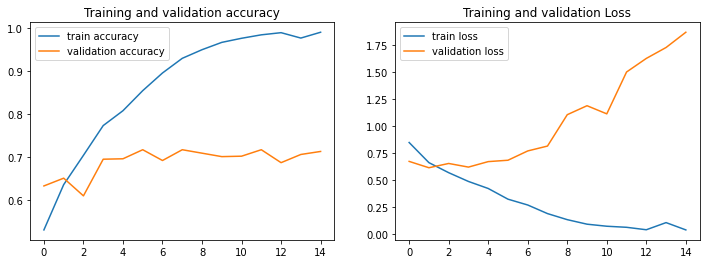

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['acc'], label='train accuracy')
ax1.plot(history.history['val_acc'], label='validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.legend()

ax2.plot(history.history['loss'], label='train loss')
ax2.plot(history.history['val_loss'], label='validation loss')
ax2.set_title('Training and validation Loss')
ax2.legend()

# Data Augmentation 을 이용하여 동일한 모델에서 overfitting 해결

- 각 epoch 마다 ImageDataGenerator 는 아래 조건의 transformation 을 각 image 에 적용하여 변형된 image 가 training 에 이용됨.  


- generated image 는 original image 와 완전히 다른 것이 아니며 같은 image 의 서로 다른 version 임


- 각 epoch 마다, 각 training sample 은 단 한번 augment 되므로 결국 2000 개의 transformed image 가 매 epoc 마다 train data 로 공급됨


    * rotation_range : degrees (0–180) 사에이서 random 하게 회전
    * width_shift and height_shift :range (전체 높이나 너비) 내에서 수직, 수평으로 random 하게 위치 이동
    * shear_range : shearing transformation 을 random 하게 적용
    * zoom_range : random 하게 zooming
    * horizontal_flip : image 의 절반을 수직으로 random 하게 flipping
    * fill_mode : 새롭게 생성된 공간은 인접 pixel 로 채움


In [0]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(150, 150),  
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [17]:
%%time
history = model.fit_generator(train_generator,
                              validation_data=validation_generator,
                              epochs=15,
                              verbose=2)

Epoch 1/15
100/100 - 17s - loss: 0.6905 - acc: 0.6175 - val_loss: 0.7287 - val_acc: 0.6590
Epoch 2/15
100/100 - 16s - loss: 0.6307 - acc: 0.6760 - val_loss: 0.5642 - val_acc: 0.7330
Epoch 3/15
100/100 - 16s - loss: 0.6109 - acc: 0.6880 - val_loss: 0.5753 - val_acc: 0.7050
Epoch 4/15
100/100 - 16s - loss: 0.5832 - acc: 0.6950 - val_loss: 0.5533 - val_acc: 0.7230
Epoch 5/15
100/100 - 16s - loss: 0.5958 - acc: 0.6810 - val_loss: 0.5320 - val_acc: 0.7470
Epoch 6/15
100/100 - 16s - loss: 0.6000 - acc: 0.7050 - val_loss: 0.5717 - val_acc: 0.7050
Epoch 7/15
100/100 - 16s - loss: 0.5929 - acc: 0.7045 - val_loss: 0.5305 - val_acc: 0.7330
Epoch 8/15
100/100 - 16s - loss: 0.5741 - acc: 0.7060 - val_loss: 0.5765 - val_acc: 0.6790
Epoch 9/15
100/100 - 16s - loss: 0.5689 - acc: 0.7125 - val_loss: 0.6269 - val_acc: 0.6600
Epoch 10/15
100/100 - 16s - loss: 0.5709 - acc: 0.7140 - val_loss: 0.5548 - val_acc: 0.7300
Epoch 11/15
100/100 - 16s - loss: 0.5749 - acc: 0.6975 - val_loss: 0.5387 - val_acc: 0.74

### overfitting 이 해결된 것을 시각화하여 확인

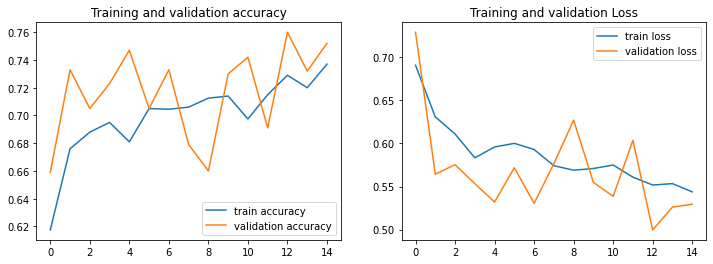

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['acc'], label='train accuracy')
ax1.plot(history.history['val_acc'], label='validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.legend()

ax2.plot(history.history['loss'], label='train loss')
ax2.plot(history.history['val_loss'], label='validation loss')
ax2.set_title('Training and validation Loss')
ax2.legend()

### 훈련된 Model 을 이용한 prediction

- 임의의 image 를 선택하여 dog, cat 구분

In [19]:
import numpy as np

test_imgs, test_labels = next(validation_generator)
predictions = model.predict(test_imgs)
predictions = [1 if predict >= 0.5 else 0 for predict in predictions]
predictions

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1]

0 ('cats'), 1 ('dogs')


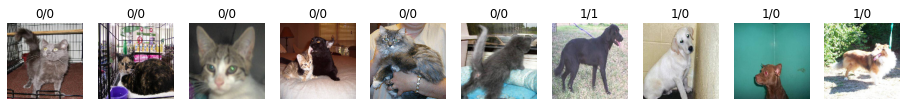

In [20]:
fig, ax = plt.subplots(1, 10, figsize=(16, 8))
ax = ax.ravel()

for i in range(10):
    img = (test_imgs[i] * 255).astype(np.uint8)
    label = (test_labels[i].astype(np.uint8))
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title("{:.0f}".format(test_labels[i]) + '/' + str(predictions[i]))
    
print("0 ('cats'), 1 ('dogs')")